<a href="https://colab.research.google.com/github/erazocar/preprocessing_ml_hw6/blob/main/preprocessing_hw6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **HW6: Preprocessing**
## **Required Libraries**

In [ ]:
#if not using google colab version of this, please disregard
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
#install scikit plot in colab environment.
!pip install scikit-plot

In [ ]:
#Scientific computing libraries
import numpy as np
import os
import pandas as pd
import scipy as sp
from scipy import interp

#performance control
import time

#Libraries from Sklearn
from sklearn.linear_model import LogisticRegression as LR
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import KFold

#Scalers
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelBinarizer

from sklearn.model_selection import cross_val_score
from sklearn import  metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from  sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import roc_curve, auc

from sklearn.datasets import load_svmlight_file

import matplotlib.pyplot as plt
import scikitplot as skplt


## **Function Definition**

In [ ]:
#Reader for each file, appended to a list.
def reader1(path):
  data = []
  filenames = os.listdir(path)
  for file in filenames:
    filepath = path + '/' + file
    d = pd.read_csv(filepath, header = None, sep=',')
    data.append(d)
  return data

In [ ]:
#Reader for each file, appended to a list.
def reader2(path):
  data = pd.read_csv(path, delim_whitespace=True, header = None)
  for i,j in enumerate(data.values):
    for k in range(len(j)):
      if (isinstance(j[k], str)):
        data.loc[i,k] = float(j[k].split(':')[1])
  return data

In [ ]:
#Logisitic regression classifier.
def training_LogReg(train_data, train_label, test_data, test_label, c):
  start = time.time()
  classifier = LR(C = c)
  classifier.fit(train_data, np.ravel(train_label))
  end = time.time()
  pred = classifier.predict(test_data)
  acc = classification_report(test_label, pred, digits = 4)

  print(acc)
  print("Time duration for Logistic Regression " + str(end - start) + "s")
  return pred

In [ ]:
#support vector machine classifier.
def training_SVM(train_data, train_label, test_data, test_label,kernel_type,c):
  start = time.time()
  classifier = SVC(C = c, kernel=kernel_type)
  classifier.fit(train_data, np.ravel(train_label))
  end = time.time()
  pred = classifier.predict(test_data)
  acc = classification_report(test_label, pred, digits = 4)

  print(acc)
  print("Time duration for " + kernel_type + " SVM " + str(end - start) + "s")
  return pred

In [ ]:
#best c classifier for the SVM
def c_selectionSVM(X_train, y_train, cross_val, kernel_type, C):
  for c in C:
    start3 = time.time()
    mod3 = SVC(C = c, kernel= kernel_type)
    mod3.fit(X_train, np.ravel(y_train))
    results3 = mod3.score(X_train, np.ravel(y_train))
    end3 = time.time()

    scores3 = cross_val_score(mod3,X_train, np.ravel(y_train), cv = cross_val)
    print("Accuracy : %.2f%%" % (results3*100) + f" for C={c}")
    print("Testing error : %.2f%%" % ((1-results3)*100), end = '\n')
    print("Cross validation error: %.2f%%" % ((1-scores3.mean()) * 100) , end = '\n')
    print("Time duration " + str(end3 - start3) + f"s for c={c}")
    print("")

In [ ]:
#best c classifier for the Linear SVM
def c_selectionLSVM(X_train, y_train, scaler,sc,cross_val, C):
  for c in C:
    start3 = time.time()
    pipe = Pipeline([(scaler, sc), ('svc', LinearSVC(C=c, tol = 0.01, max_iter=1500))])
    pipe.fit(X_train, np.ravel(y_train))
    results3 = pipe.score(X_train, np.ravel(y_train))
    end3 = time.time()

    scores3 = cross_val_score(pipe,X_train, np.ravel(y_train), cv = cross_val)
    print("Accuracy : %.2f%%" % (results3*100) + f" for C={c}")
    print("Testing error : %.2f%%" % ((1-results3)*100), end = '\n')
    print("Cross validation error: %.2f%%" % ((1-scores3.mean()) * 100) , end = '\n')
    print("Time duration " + str(end3 - start3) + f"s for c={c}")
    print("")

In [ ]:
#best c classifier for the SVM
def SVM_pipeliner(X_train, y_train, scaler, sc, c, tolerance):
  start = time.time()
  svm = LinearSVC(C=c, tol = tolerance)

  pipe = Pipeline([(scaler, sc), ('svc', CalibratedClassifierCV(svm))])
  pipe.fit(X_train, y_train)
  end = time.time()
  
  #print(acc)
  print("Time duration for " + scaler + " SVM " + str(end - start) + "s")
  return pipe

In [ ]:
#Implementation from StackOF#39685740 for AUC_ROC scores
def class_report(y_true, y_pred, y_score=None, average='micro'):
    if y_true.shape != y_pred.shape:
        print("Error! y_true %s is not the same shape as y_pred %s" % (
              y_true.shape,
              y_pred.shape)
        )
        return

    lb = LabelBinarizer()

    if len(y_true.shape) == 1:
        lb.fit(y_true)

    #Value counts of predictions
    labels, cnt = np.unique(
        y_pred,
        return_counts=True)
    n_classes = len(labels)
    pred_cnt = pd.Series(cnt, index=labels)

    metrics_summary = precision_recall_fscore_support(
            y_true=y_true,
            y_pred=y_pred,
            labels=labels)

    avg = list(precision_recall_fscore_support(
            y_true=y_true, 
            y_pred=y_pred,
            average='weighted'))

    metrics_sum_index = ['precision', 'recall', 'f1-score', 'support']
    class_report_df = pd.DataFrame(
        list(metrics_summary),
        index=metrics_sum_index,
        columns=labels)

    support = class_report_df.loc['support']
    total = support.sum() 
    class_report_df['avg / total'] = avg[:-1] + [total]

    class_report_df = class_report_df.T
    class_report_df['pred'] = pred_cnt
    class_report_df['pred'].iloc[-1] = total

    if not (y_score is None):
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for label_it, label in enumerate(labels):
            fpr[label], tpr[label], _ = roc_curve(
                (y_true == label).astype(int), 
                y_score[:, label_it])

            roc_auc[label] = auc(fpr[label], tpr[label])

        if average == 'micro':
            if n_classes <= 2:
                fpr["avg / total"], tpr["avg / total"], _ = roc_curve(
                    lb.transform(y_true).ravel(), 
                    y_score[:, 1].ravel())
            else:
                fpr["avg / total"], tpr["avg / total"], _ = roc_curve(
                        lb.transform(y_true).ravel(), 
                        y_score.ravel())

            roc_auc["avg / total"] = auc(
                fpr["avg / total"], 
                tpr["avg / total"])

        elif average == 'macro':
            # First aggregate all false positive rates
            all_fpr = np.unique(np.concatenate([
                fpr[i] for i in labels]
            ))

            # Then interpolate all ROC curves at this points
            mean_tpr = np.zeros_like(all_fpr)
            for i in labels:
                mean_tpr += interp(all_fpr, fpr[i], tpr[i])

            # Finally average it and compute AUC
            mean_tpr /= n_classes

            fpr["macro"] = all_fpr
            tpr["macro"] = mean_tpr

            roc_auc["avg / total"] = auc(fpr["macro"], tpr["macro"])

        class_report_df['AUC'] = pd.Series(roc_auc)

    return class_report_df

## **Preprocessing**

In [ ]:
#Read paths and create contents for the documents.
#Please put the local paths were the queries and docs are located when running.
#Data for problem 1
folder1 = '/content/drive/MyDrive/MachineLearning/homework-6/covtype'
example1 = reader1(folder1)

covertype_y_train_index = np.asarray(example1[1]).flatten() - 1
covertype_y_test_index = np.asarray(example1[2]).flatten() - 1
covertype_labels = np.asarray(example1[0].iloc[:,-1]).flatten()
covertype_X = np.asarray(example1[0].iloc[:, :-1].values)

covertype_y_train = covertype_labels[covertype_y_train_index]
covertype_y_test = covertype_labels[covertype_y_test_index]
covertype_X_train = covertype_X[covertype_y_train_index]
covertype_X_test = covertype_X[covertype_y_test_index]

In [24]:
#Read paths and create contents for the documents.
#Please put the local paths were the queries and docs are located when running.
#Data for problem 1
file1 = '/content/drive/MyDrive/MachineLearning/homework-6/breast_cancer/breast-cancer-scale-train-indices.txt'
file2 = '/content/drive/MyDrive/MachineLearning/homework-6/breast_cancer/breast-cancer-scale-test-indices.txt'
file3 = '/content/drive/MyDrive/MachineLearning/homework-6/breast_cancer/breast-cancer_scale.txt'

#Reading and appending the files.
breast_y_train_label= reader2(file1)
breast_y_train_index = np.asarray(breast_y_train_label).flatten() - 1
breast_y_test_label= reader2(file2)
breast_y_test_index = np.asarray(breast_y_test_label).flatten() - 1
breast_X= load_svmlight_file(file3)

#Append the training and testing dataset together
breast_y_train = breast_X[1][breast_y_train_index]
breast_y_test = breast_X[1][breast_y_test_index]
breast_X_train = breast_X[0][breast_y_train_index]
breast_X_test = breast_X[0][breast_y_test_index]

In [25]:
#Read paths and create contents for the documents.
#Please put the local paths were the queries and docs are located when running.
#Data for problem 2
file4 = '/content/drive/MyDrive/MachineLearning/homework-6/sonar/sonar-scale-train-indices.txt'
file5 = '/content/drive/MyDrive/MachineLearning/homework-6/sonar/sonar-scale-test-indices.txt'
file6 = '/content/drive/MyDrive/MachineLearning/homework-6/sonar/sonar_scale.txt'

#Reading and appendinig the files.
sonar_y_train_label= reader2(file4)
sonar_y_train_index = np.asarray(sonar_y_train_label).flatten() - 1
sonar_y_test_label= reader2(file5)
sonar_y_test_index = np.asarray(sonar_y_test_label).flatten() - 1
sonar_X= load_svmlight_file(file6)

#Creating sparse labels from labels
sonar_y_train = sonar_X[1][sonar_y_train_index]
sonar_y_test = sonar_X[1][sonar_y_test_index]
sonar_X_train = sonar_X[0][sonar_y_train_index]
sonar_X_test = sonar_X[0][sonar_y_test_index]

## **Problem 1**
Using k-FOLD cross validation with K = 5 for selecting the best C parameter
for logisitic regression.

### *For the breast cancer data*

In [ ]:
#Evaluate which is the best accuracy for the cross validation
kcv = KFold(n_splits=5)

#List with k's iterating from 0.1 to 10
C = [0.1, 1, 10, 100, 1000]

In [27]:
#Selection of best C for logistic regression
for c in C:
  start = time.time()
  mod1 = LR(C = c)
  mod1.fit(breast_X_train, np.ravel(breast_y_train))
  results = mod1.score(breast_X_train, np.ravel(breast_y_train))
  end = time.time()

  scores = cross_val_score(mod1,breast_X_train, np.ravel(breast_y_train), cv = kcv)
  print("Accuracy : %.2f%%" % (results*100) + f" for C={c}")
  print("Testing error : %.2f%%" % ((1-results)*100), end = '\n')
  print("Cross validation error: %.2f%%" % ((1-scores.mean()) * 100) , end = '\n')
  print("Time duration " + str(end - start) + f"s for c={c}")
  print("")

Accuracy : 97.20% for C=0.1
Testing error : 2.80%
Cross validation error: 3.80%
Time duration 0.01815176010131836s for c=0.1

Accuracy : 97.60% for C=1
Testing error : 2.40%
Cross validation error: 3.20%
Time duration 0.0137176513671875s for c=1

Accuracy : 97.60% for C=10
Testing error : 2.40%
Cross validation error: 3.20%
Time duration 0.015437841415405273s for c=10

Accuracy : 97.60% for C=100
Testing error : 2.40%
Cross validation error: 3.40%
Time duration 0.014872312545776367s for c=100

Accuracy : 97.60% for C=1000
Testing error : 2.40%
Cross validation error: 3.40%
Time duration 0.01784372329711914s for c=1000



Best C for the breast data is c = 1. Use this to fit a model and predict.

In [28]:
#Predict breast cancer labels
breast_prediction = training_LogReg(breast_X_train, breast_y_train, breast_X_test, breast_y_test, 1)

              precision    recall  f1-score   support

         2.0     0.9828    0.9580    0.9702       119
         4.0     0.9254    0.9688    0.9466        64

    accuracy                         0.9617       183
   macro avg     0.9541    0.9634    0.9584       183
weighted avg     0.9627    0.9617    0.9619       183

Time duration for Logistic Regression 0.02167654037475586s


In [29]:
breast_prediction

array([2., 4., 4., 2., 2., 2., 2., 4., 2., 4., 2., 2., 2., 2., 2., 4., 4.,
       4., 2., 2., 4., 4., 2., 4., 2., 4., 2., 2., 4., 2., 2., 2., 2., 4.,
       4., 2., 4., 2., 4., 2., 4., 2., 2., 2., 2., 2., 2., 2., 2., 4., 2.,
       4., 2., 4., 4., 2., 4., 2., 2., 4., 2., 4., 2., 2., 4., 4., 4., 2.,
       4., 4., 2., 4., 2., 4., 2., 2., 4., 4., 4., 4., 2., 4., 4., 4., 4.,
       4., 2., 4., 4., 2., 4., 4., 2., 4., 2., 2., 2., 2., 4., 4., 2., 2.,
       2., 4., 2., 2., 2., 4., 2., 2., 2., 2., 2., 2., 4., 2., 2., 2., 2.,
       2., 4., 2., 2., 2., 4., 2., 2., 2., 2., 2., 2., 2., 2., 2., 4., 2.,
       2., 2., 2., 4., 2., 2., 4., 2., 2., 2., 4., 4., 2., 4., 4., 4., 2.,
       4., 2., 2., 2., 4., 2., 2., 2., 2., 2., 2., 2., 2., 4., 2., 4., 2.,
       2., 2., 2., 4., 2., 2., 2., 2., 2., 2., 2., 4., 4.])

### *For the sonar data*

In [30]:
for c in C:
  start2 = time.time()
  mod2 = LR(C = c, max_iter=1000)
  mod2.fit(sonar_X_train, np.ravel(sonar_y_train))
  results2 = mod2.score(sonar_X_train, np.ravel(sonar_y_train))
  end2 = time.time()

  scores2 = cross_val_score(mod2,sonar_X_train, np.ravel(sonar_y_train), cv = kcv)
  print("Accuracy : %.2f%%" % (results2*100) + f" for C={c}")
  print("Testing error : %.2f%%" % ((1-results2)*100), end = '\n')
  print("Cross validation error: %.2f%%" % ((1-scores2.mean()) * 100) , end = '\n')
  print("Time duration " + str(end2 - start2) + f"s for c={c}")
  print("")

Accuracy : 84.00% for C=0.1
Testing error : 16.00%
Cross validation error: 60.00%
Time duration 0.008052587509155273s for c=0.1

Accuracy : 90.67% for C=1
Testing error : 9.33%
Cross validation error: 51.33%
Time duration 0.020798921585083008s for c=1

Accuracy : 96.67% for C=10
Testing error : 3.33%
Cross validation error: 46.67%
Time duration 0.04181480407714844s for c=10

Accuracy : 100.00% for C=100
Testing error : 0.00%
Cross validation error: 46.00%
Time duration 0.11158490180969238s for c=100

Accuracy : 100.00% for C=1000
Testing error : 0.00%
Cross validation error: 46.00%
Time duration 0.14009666442871094s for c=1000



In [31]:
#Predict sonar labels
sonar_prediction = training_LogReg(sonar_X_train, sonar_y_train, sonar_X_test, sonar_y_test, 0.1)

              precision    recall  f1-score   support

        -1.0     0.7105    1.0000    0.8308        27
         1.0     1.0000    0.6452    0.7843        31

    accuracy                         0.8103        58
   macro avg     0.8553    0.8226    0.8075        58
weighted avg     0.8652    0.8103    0.8059        58

Time duration for Logistic Regression 0.016580581665039062s


In [32]:
sonar_prediction

array([ 1., -1., -1., -1.,  1.,  1.,  1., -1., -1.,  1., -1., -1.,  1.,
        1., -1.,  1.,  1.,  1., -1.,  1.,  1.,  1.,  1.,  1.,  1., -1.,
       -1.,  1.,  1.,  1.,  1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1.])

## **Problem 2**
Using k-FOLD cross validation with K = 5 for selecting the best C parameter
for SVM.

### *For the breast cancer data*

In [33]:
#Linear classifier for selection of best C
c_selectionSVM(breast_X_train, breast_y_train, kcv, 'linear', C)

Accuracy : 97.60% for C=0.1
Testing error : 2.40%
Cross validation error: 3.40%
Time duration 0.012686491012573242s for c=0.1

Accuracy : 98.00% for C=1
Testing error : 2.00%
Cross validation error: 2.80%
Time duration 0.006432771682739258s for c=1

Accuracy : 97.80% for C=10
Testing error : 2.20%
Cross validation error: 3.20%
Time duration 0.009187459945678711s for c=10

Accuracy : 97.80% for C=100
Testing error : 2.20%
Cross validation error: 3.00%
Time duration 0.014660835266113281s for c=100

Accuracy : 97.80% for C=1000
Testing error : 2.20%
Cross validation error: 3.00%
Time duration 0.0524752140045166s for c=1000



Best c for linear SVM is 1.

In [34]:
#Polynomial kernel for selection of best C
c_selectionSVM(breast_X_train, breast_y_train, kcv, 'poly', C)

Accuracy : 97.80% for C=0.1
Testing error : 2.20%
Cross validation error: 2.40%
Time duration 0.010999679565429688s for c=0.1

Accuracy : 98.60% for C=1
Testing error : 1.40%
Cross validation error: 3.00%
Time duration 0.006798505783081055s for c=1

Accuracy : 99.60% for C=10
Testing error : 0.40%
Cross validation error: 4.40%
Time duration 0.007773399353027344s for c=10

Accuracy : 100.00% for C=100
Testing error : 0.00%
Cross validation error: 5.20%
Time duration 0.008168458938598633s for c=100

Accuracy : 100.00% for C=1000
Testing error : 0.00%
Cross validation error: 5.20%
Time duration 0.009651422500610352s for c=1000



Best c for polynomial kernel SVM is 0.1.

In [35]:
#RBF kernel for selection of best C
c_selectionSVM(breast_X_train, breast_y_train, kcv, 'rbf', C)

Accuracy : 97.20% for C=0.1
Testing error : 2.80%
Cross validation error: 3.00%
Time duration 0.014107227325439453s for c=0.1

Accuracy : 98.00% for C=1
Testing error : 2.00%
Cross validation error: 3.00%
Time duration 0.00538945198059082s for c=1

Accuracy : 99.40% for C=10
Testing error : 0.60%
Cross validation error: 3.80%
Time duration 0.005471229553222656s for c=10

Accuracy : 100.00% for C=100
Testing error : 0.00%
Cross validation error: 4.60%
Time duration 0.007921695709228516s for c=100

Accuracy : 100.00% for C=1000
Testing error : 0.00%
Cross validation error: 4.60%
Time duration 0.007622480392456055s for c=1000



Best c for RBF kernel SVM is 1.

In [36]:
#Predict breast cancer label for linear SVM
breast_pred_SMV_lin = training_SVM(breast_X_train, breast_y_train, breast_X_test, breast_y_test, 'linear', 1)

              precision    recall  f1-score   support

         2.0     0.9913    0.9580    0.9744       119
         4.0     0.9265    0.9844    0.9545        64

    accuracy                         0.9672       183
   macro avg     0.9589    0.9712    0.9645       183
weighted avg     0.9686    0.9672    0.9674       183

Time duration for linear SVM 0.01025080680847168s


In [37]:
#Predict breast cancer label for polynomial SVM
breast_pred_SMV_POLY = training_SVM(breast_X_train, breast_y_train, breast_X_test, breast_y_test, 'poly', 0.1)

              precision    recall  f1-score   support

         2.0     1.0000    0.9496    0.9741       119
         4.0     0.9143    1.0000    0.9552        64

    accuracy                         0.9672       183
   macro avg     0.9571    0.9748    0.9647       183
weighted avg     0.9700    0.9672    0.9675       183

Time duration for poly SVM 0.007169246673583984s


In [38]:
#Predict breast cancer label for RBF SVM
breast_pred_SMV_RBF = training_SVM(breast_X_train, breast_y_train, breast_X_test, breast_y_test, 'rbf', 1)

              precision    recall  f1-score   support

         2.0     0.9913    0.9580    0.9744       119
         4.0     0.9265    0.9844    0.9545        64

    accuracy                         0.9672       183
   macro avg     0.9589    0.9712    0.9645       183
weighted avg     0.9686    0.9672    0.9674       183

Time duration for rbf SVM 0.008792638778686523s


### *For the sonar data*

In [39]:
#Linear classifier for selection of best C
c_selectionSVM(sonar_X_train, sonar_y_train, kcv, 'linear', C)

Accuracy : 85.33% for C=0.1
Testing error : 14.67%
Cross validation error: 54.67%
Time duration 0.013089895248413086s for c=0.1

Accuracy : 92.67% for C=1
Testing error : 7.33%
Cross validation error: 48.67%
Time duration 0.008662223815917969s for c=1

Accuracy : 98.67% for C=10
Testing error : 1.33%
Cross validation error: 49.33%
Time duration 0.009181022644042969s for c=10

Accuracy : 100.00% for C=100
Testing error : 0.00%
Cross validation error: 48.67%
Time duration 0.008723020553588867s for c=100

Accuracy : 100.00% for C=1000
Testing error : 0.00%
Cross validation error: 48.67%
Time duration 0.008589744567871094s for c=1000



Best c for linear SVM is 0.1.

In [40]:
#Polynomial kernel for selection of best C
c_selectionSVM(sonar_X_train, sonar_y_train, kcv, 'poly', C)

Accuracy : 78.67% for C=0.1
Testing error : 21.33%
Cross validation error: 54.00%
Time duration 0.01251673698425293s for c=0.1

Accuracy : 99.33% for C=1
Testing error : 0.67%
Cross validation error: 54.67%
Time duration 0.009649991989135742s for c=1

Accuracy : 100.00% for C=10
Testing error : 0.00%
Cross validation error: 48.67%
Time duration 0.009096145629882812s for c=10

Accuracy : 100.00% for C=100
Testing error : 0.00%
Cross validation error: 48.67%
Time duration 0.009668111801147461s for c=100

Accuracy : 100.00% for C=1000
Testing error : 0.00%
Cross validation error: 48.67%
Time duration 0.008995532989501953s for c=1000



Best c for polynomial kernel SVM is 1.

In [41]:
#RBF kernel for selection of best C
c_selectionSVM(sonar_X_train, sonar_y_train, kcv, 'rbf', C)

Accuracy : 57.33% for C=0.1
Testing error : 42.67%
Cross validation error: 96.00%
Time duration 0.016573190689086914s for c=0.1

Accuracy : 97.33% for C=1
Testing error : 2.67%
Cross validation error: 66.67%
Time duration 0.007044553756713867s for c=1

Accuracy : 100.00% for C=10
Testing error : 0.00%
Cross validation error: 55.33%
Time duration 0.007279157638549805s for c=10

Accuracy : 100.00% for C=100
Testing error : 0.00%
Cross validation error: 55.33%
Time duration 0.010590791702270508s for c=100

Accuracy : 100.00% for C=1000
Testing error : 0.00%
Cross validation error: 55.33%
Time duration 0.010941505432128906s for c=1000



Best c for RBF RBF SVM is 1.

In [42]:
#Predict sonar label for linear SVM
sonar_pred_SMV_lin = training_SVM(sonar_X_train, sonar_y_train, sonar_X_test, sonar_y_test, 'linear', 0.1)

              precision    recall  f1-score   support

        -1.0     0.6579    0.9259    0.7692        27
         1.0     0.9000    0.5806    0.7059        31

    accuracy                         0.7414        58
   macro avg     0.7789    0.7533    0.7376        58
weighted avg     0.7873    0.7414    0.7354        58

Time duration for linear SVM 0.013342142105102539s


In [43]:
#Predict sonar label for polynomial SVM
sonar_pred_SMV_POLY = training_SVM(sonar_X_train, sonar_y_train, sonar_X_test, sonar_y_test, 'poly', 1)

              precision    recall  f1-score   support

        -1.0     0.7941    1.0000    0.8852        27
         1.0     1.0000    0.7742    0.8727        31

    accuracy                         0.8793        58
   macro avg     0.8971    0.8871    0.8790        58
weighted avg     0.9042    0.8793    0.8786        58

Time duration for poly SVM 0.00928354263305664s


In [44]:
#Predict sonar label for RBF SVM
sonar_pred_SMV_RBF = training_SVM(sonar_X_train, sonar_y_train, sonar_X_test, sonar_y_test, 'rbf', 1)

              precision    recall  f1-score   support

        -1.0     0.7297    1.0000    0.8437        27
         1.0     1.0000    0.6774    0.8077        31

    accuracy                         0.8276        58
   macro avg     0.8649    0.8387    0.8257        58
weighted avg     0.8742    0.8276    0.8245        58

Time duration for rbf SVM 0.008685111999511719s


## **Problem 3**

To analyze the performance and best c parameter for each of the scaling types, a subsizing of the training datasets was done to shorten the timing of the simulations.

In [ ]:
#Standard scaler.
sscaler1 = StandardScaler()

In [ ]:
#Min max scaler.
sscaler2 = MinMaxScaler()

In [ ]:
#Normalizing data scaler.
sscaler3 = Normalizer()

In [ ]:
#standard scaler best c
c_selectionLSVM(covertype_X_train[:10000], covertype_y_train[:10000],'scaler',sscaler1, kcv, C)

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarn

Accuracy : 67.00% for C=0.1
Testing error : 33.00%
Cross validation error: 49.91%
Time duration 6.652710437774658s for c=0.1



/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarn

Accuracy : 67.30% for C=1
Testing error : 32.70%
Cross validation error: 50.20%
Time duration 11.288730144500732s for c=1



/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarn

Accuracy : 67.14% for C=10
Testing error : 32.86%
Cross validation error: 50.48%
Time duration 13.491381168365479s for c=10



/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarn

Accuracy : 58.86% for C=100
Testing error : 41.14%
Cross validation error: 57.74%
Time duration 14.303043365478516s for c=100



/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarn

Accuracy : 52.85% for C=1000
Testing error : 47.15%
Cross validation error: 58.53%
Time duration 14.173905611038208s for c=1000



/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Best C for standard scaler is 0.1

In [ ]:
#minmax scaling best c
c_selectionLSVM(covertype_X_train[:10000], covertype_y_train[:10000],'minmax',sscaler2, kcv, C)

Accuracy : 65.79% for C=0.1
Testing error : 34.21%
Cross validation error: 49.68%
Time duration 0.10467934608459473s for c=0.1

Accuracy : 66.83% for C=1
Testing error : 33.17%
Cross validation error: 50.26%
Time duration 0.34876036643981934s for c=1

Accuracy : 67.26% for C=10
Testing error : 32.74%
Cross validation error: 50.38%
Time duration 2.484750747680664s for c=10



/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarn

Accuracy : 64.79% for C=100
Testing error : 35.21%
Cross validation error: 51.45%
Time duration 4.575580835342407s for c=100



/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarn

Accuracy : 56.43% for C=1000
Testing error : 43.57%
Cross validation error: 63.85%
Time duration 4.789214611053467s for c=1000



/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Best C for minmax scaling is 1.

In [ ]:
#normalizing data scaling best c
c_selectionLSVM(covertype_X_train[:10000], covertype_y_train[:10000],'normalize',sscaler3, kcv, C)

Accuracy : 38.41% for C=0.1
Testing error : 61.59%
Cross validation error: 83.86%
Time duration 0.08797335624694824s for c=0.1

Accuracy : 46.27% for C=1
Testing error : 53.73%
Cross validation error: 76.08%
Time duration 0.25222063064575195s for c=1

Accuracy : 51.70% for C=10
Testing error : 48.30%
Cross validation error: 68.99%
Time duration 1.6026058197021484s for c=10



/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarn

Accuracy : 57.14% for C=100
Testing error : 42.86%
Cross validation error: 63.47%
Time duration 7.190650701522827s for c=100



/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarn

Accuracy : 45.82% for C=1000
Testing error : 54.18%
Cross validation error: 70.72%
Time duration 7.764643430709839s for c=1000



/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Best C for normalized scaling is 10.

### Standard Scaler predictions and ROC's

In [ ]:
#Predict sonar label for linear SVM with standard scaler
covertype_pred_SMV_lin1 = SVM_pipeliner(covertype_X_train, covertype_y_train , 'scaler', sscaler1, 1, 0.1)

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarn

Time duration for scaler SVM 5326.947482824326s


In [21]:
class_report(covertype_y_test, covertype_pred_SMV_lin1.predict(covertype_X_test), y_score=covertype_pred_SMV_lin1.predict_proba(covertype_X_test))

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support,pred,AUC
1,0.707860,0.695141,0.701443,21259.0,20877.0,0.853142
2,0.739417,0.795189,0.766289,28226.0,30355.0,0.839028
3,0.619701,0.860697,0.720583,3618.0,5025.0,0.983111
4,0.727273,0.115523,0.199377,277.0,44.0,0.993900
6,0.421788,0.086832,0.144015,1739.0,358.0,0.411145
7,0.730236,0.500238,0.593741,2105.0,1442.0,0.309243
avg / total,0.699357,0.715530,0.700570,57224.0,57224.0,0.958195


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


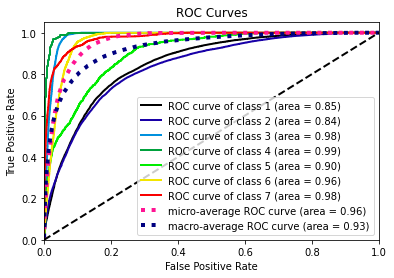

In [23]:
skplt.metrics.plot_roc_curve(covertype_y_test, covertype_pred_SMV_lin1.predict_proba(covertype_X_test))
plt.show()

### MinMax Scaler predictions and ROC's

In [ ]:
#Predict sonar label for linear SVM with minmax scaler
covertype_pred_SMV_lin2 = SVM_pipeliner(covertype_X_train, covertype_y_train ,'minmax', sscaler2, 1, 0.01)

Time duration for minmax SVM 244.05137848854065s


In [ ]:
class_report(covertype_y_test, covertype_pred_SMV_lin2.predict(covertype_X_test), y_score=covertype_pred_SMV_lin2.predict_proba(covertype_X_test))

,precision,recall,f1-score,support,pred,AUC
1,0.707605,0.693259,0.700359,21259.0,20828.0,0.852480
2,0.739007,0.794905,0.765938,28226.0,30361.0,0.839298
3,0.620758,0.859591,0.720909,3618.0,5010.0,0.982924
4,0.666667,0.209386,0.318681,277.0,87.0,0.994350
5,0.500000,0.004561,0.009040,877.0,8.0,0.901729
6,0.436578,0.085106,0.142445,1739.0,339.0,0.963782
7,0.720027,0.502138,0.591660,2105.0,1468.0,0.975906
avg / total,0.706462,0.715168,0.700606,58101.0,58101.0,0.958353


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


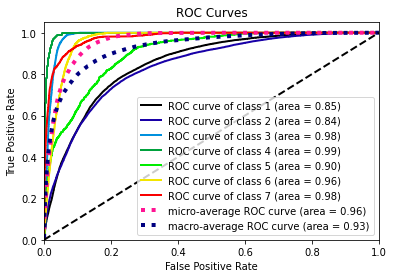

In [ ]:
skplt.metrics.plot_roc_curve(covertype_y_test, covertype_pred_SMV_lin2.predict_proba(covertype_X_test))
plt.show()

### Normalizer Scaler predictions and ROC's

In [ ]:
#Predict sonar label for linear SVM with normalize scaler
covertype_pred_SMV_lin3 = SVM_pipeliner(covertype_X_train, covertype_y_train ,'normalize', sscaler3, 10, 0.001)

Time duration for normalize SVM 1444.3962380886078s


In [ ]:
class_report(covertype_y_test, covertype_pred_SMV_lin3.predict(covertype_X_test), y_score=covertype_pred_SMV_lin3.predict_proba(covertype_X_test))

,precision,recall,f1-score,support,pred,AUC
1,0.707639,0.693259,0.700375,21259.0,20827.0,0.852480
2,0.739007,0.794905,0.765938,28226.0,30361.0,0.839297
3,0.620635,0.859591,0.720825,3618.0,5011.0,0.982924
4,0.666667,0.209386,0.318681,277.0,87.0,0.994351
5,0.500000,0.004561,0.009040,877.0,8.0,0.901757
6,0.434911,0.084531,0.141550,1739.0,338.0,0.963782
7,0.720218,0.502613,0.592054,2105.0,1469.0,0.975908
avg / total,0.706423,0.715168,0.700594,58101.0,58101.0,0.958353


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


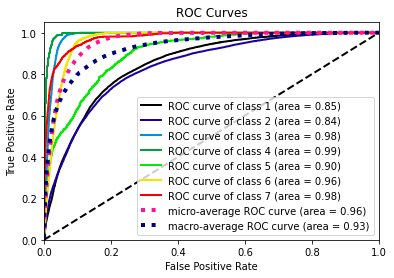

In [ ]:
skplt.metrics.plot_roc_curve(covertype_y_test, covertype_pred_SMV_lin3.predict_proba(covertype_X_test))
plt.show()